In [11]:
import matplotlib.pyplot as plt 
import torch 
from torch import optim 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [12]:
class BaseClassifier(nn.Module):
    def __init__(self, in_dim, feature_dim,out_dim):
        super(BaseClassifier, self).__init__()
        self.classifier = nn.Sequential(
             nn.Linear(in_dim,feature_dim,bias=True),
             nn.ReLU(),
             nn.Linear(feature_dim,out_dim,bias=True)
        )
        
    def forward(self,x):
        return self.classifier(x)

In [13]:
# load in MINST dataset from PyTorch
train_dataset = MNIST(".", train=True,download=True,transform=ToTensor())
test_dataset = MNIST(".", train=False,download=True,transform=ToTensor())
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False)


In [14]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [15]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()

In [16]:
train_loader

In [17]:
test_loader

Epoch: 1, Train Loss: 0.2193
Epoch: 2, Train Loss: 0.1367
Epoch: 3, Train Loss: 0.1111
Epoch: 4, Train Loss: 0.1037
Epoch: 5, Train Loss: 0.0858
Epoch: 6, Train Loss: 0.0874
Epoch: 7, Train Loss: 0.0873
Epoch: 8, Train Loss: 0.0840
Epoch: 9, Train Loss: 0.0795
Epoch: 10, Train Loss: 0.0758
Epoch: 11, Train Loss: 0.0663
Epoch: 12, Train Loss: 0.0676
Epoch: 13, Train Loss: 0.0660
Epoch: 14, Train Loss: 0.0691
Epoch: 15, Train Loss: 0.0646
Epoch: 16, Train Loss: 0.0596
Epoch: 17, Train Loss: 0.0719
Epoch: 18, Train Loss: 0.0470
Epoch: 19, Train Loss: 0.0551
Epoch: 20, Train Loss: 0.0694
Training Loss List: [0.2192963766944863, 0.1367452480452461, 0.11114788928193532, 0.10371638271391817, 0.08583619765144451, 0.08741441990904408, 0.08731875898760925, 0.08403491787950639, 0.07946499405431295, 0.07577079029164673, 0.06631970921278811, 0.06760878984342722, 0.065986861228641, 0.06913397272961953, 0.06458817897859896, 0.0596109335083622, 0.07185650065968975, 0.046980421427541934, 0.055129606105

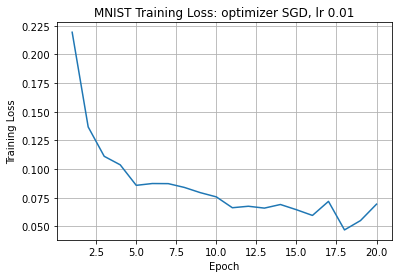

In [27]:

# Instantiate model, optimizer, and hyperparameters
in_dim, feature_dim, out_dim = 784, 256, 10
lr = 0.01
loss_fn = nn.CrossEntropyLoss()
epochs = 20
classifier = BaseClassifier(in_dim, feature_dim, out_dim)
optimizer = optim.Adam(classifier.parameters(), lr=lr)

# Training function
def train(classifier=classifier, optimizer=optimizer, epochs=epochs, loss_fn=loss_fn):
    classifier.train()
    loss_list = []

    for epoch in range(epochs):
        running_loss = 0.0
        for data, target in train_loader:
            data = data.flatten(start_dim=1)

            optimizer.zero_grad()
            out = classifier(data)
            computed_loss = loss_fn(out, target)
            computed_loss.backward()
            optimizer.step()

            running_loss += computed_loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_list.append(epoch_loss)
        print(f"Epoch: {epoch + 1}, Train Loss: {epoch_loss:.4f}")

    print("Training Loss List:", loss_list)
    return loss_list

# Run training and store the loss list
loss_list = train()

# Plot training loss
plt.plot([i for i in range(1, epochs + 1)], loss_list)
plt.xlabel('Epoch')  # Corrected
plt.ylabel('Training Loss')  # Corrected
plt.title(f"MNIST Training Loss: optimizer SGD, lr {lr}")
plt.grid(True)
plt.show()

# Save model checkpoint (weights only)
torch.save(classifier.state_dict(), 'mnist.pt')


In [28]:


def test(classifier, lossfn, test_loader, device='cpu'):
    classifier.eval()
    classifier.to(device)  # Ensure model is on the correct device (CPU or GPU)
    
    accuracy = 0.0
    computed_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)  # Move data to the device
            data = data.flatten(start_dim=1)

            # Forward pass through the model
            out = classifier(data)
            _, preds = torch.max(out, dim=1)

            # Accumulate loss and accuracy
            computed_loss += lossfn(out, target).item()  # Loss for this batch
            accuracy += (preds == target).sum().item()  # Number of correct predictions
            total_samples += target.size(0)  # Total number of samples

    # Calculate average loss and accuracy
    avg_loss = computed_loss / len(test_loader)
    acc_percent = (accuracy / total_samples) * 100.0

    # Print the results
    print(f"Test loss: {avg_loss:.4f}, Test accuracy: {acc_percent:.2f}%")


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier.to(device)  # Ensure model is on the correct device
test(classifier=classifier, lossfn=loss_fn, test_loader=test_loader, device=device)


Test loss: 0.3812, Test accuracy: 97.21%


### Hyperparameter tunning

<div class="alert alert alert-block alert-info">
    
*  for optimizer SGD got accuracy 91% for epochs 50  test loss is 0.3007
    
*  for optimizer SGD got accuracy 89.46% for epochs 20 test loss is 0.4034
    
*  for optimizer SGD got accuracy 98.05% for epochs 20 test loss is 0.0790  for momentum=0.9
   
*  for optimizer SGD got accuracy 97.91% for epochs 20 test loss is 0.0647 for momentum=0.9 nesterov=True  
    
*  for optimizer Adam got accuracy 98.10% epochs 20  test loss is 0.0807
    <div>

<div class = " alert alert alert-block alert-success">
we are using Adam for ease speed and strong performance

<div class = " alert alert alert-block alert-warning">
    Momentum in PyTorch's SGD helps the optimizer move faster and more smoothly by using past gradients to influence the current update. It speeds up convergence and reduces oscillations.

<div class = " alert alert alert-block alert-warning">
* nesterov=True in PyTorch's SGD enables Nesterov Accelerated Gradient (NAG), a variation of momentum that looks ahead before calculating the gradient.

* Effect:
It gives a more accurate update by computing the gradient after making a partial step in the direction of the momentum.

<div class = " alert alert alert-block alert-success">
super() is used in  BaseClassifier to properly initialize nn.Module.
This is required in PyTorch neural network classes to ensure training and inference work correctly.